In [1]:
using DifferentialEquations, Flux, Zygote, LinearAlgebra, ForwardDiff, FiniteDiff, Plots, Random

In [2]:
using LNNProject, BenchmarkTools
Threads.nthreads()

11

## Demonstration of the framework

## Analytical solution
First we solve the well known double pendulum model using Lagrangian Mechanics
Note: the parameters have been set to the constants for mass and pendulum lengthhave been set to 


m1 = m2 = l1 = l2 = 1 

while the gravitational g constant has been set to
g = 9.81


In [3]:
function analytical_RHS(du, u, _not_used, t=0)
    t1, t2, w1, w2 = u[1], u[2], u[3], u[4]
    m1, m2, l1, l2, g = (1, 1, 1, 1, 9.81)
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * cos(t1 - t2)
    a2 = (l1 / l2) * cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2^2) * sin(t1 - t2) - (g / l1) * sin(t1)
    f2 = (l1 / l2) * (w1^2) * sin(t1 - t2) - (g / l2) * sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2)
    du .= [w1, w2, g1, g2]
end
function analytical_Lagrangian(x)
    m1, m2, l1, l2, g = (1,1,1,1,9.81)
    θ1, θ2, v1, v2 = x[1], x[2], x[3], x[4]
    term1 = 0.5*(m1+m2)*l1^2*v1^2
    term2 = 0.5*m2*l2^2*v2^2
    term3 = m2*l1*l2*v1*v2*cos(θ1-θ2)
    term4 = (m1+m2)*g*l1*cos(θ1)
    term5 = m2*g*l2*cos(θ2)
    return term1 + term2 + term3 + term4 + term5
end

analytical_Lagrangian (generic function with 1 method)

In [4]:
function energy(q, q_dot, m1, m2, l1, l2, g)
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)^2
  T2 = 0.5 * m2 * ((l1 * w1)^2 + (l2 * w2)^2 +
                    2 * l1 * l2 * w1 * w2 * cos(t1 - t2))
  T = T1 + T2
  
  # potential energy (V)
  y1 = -l1 * cos(t1)
  y2 = y1 - l2 * cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T + V
end

energy (generic function with 1 method)

The analytical expression for the Lagrangian is therefore:
$$
\begin{align}
L = & \frac{1}{2}(m_1 + m_2) l_1^2 \dot{\theta}_1^2 +
	\frac{1}{2}m_2 l_2^2 \dot{\theta}_2^2 + m_2l_1l_2\dot{\theta}_1\dot{\theta}_2
	\cos(\theta_1 - \theta_2)\nonumber\\[3pt]
     &+ (m_1 + m_2) g l_1 \cos\theta_1 + m_2 g l_2\cos\theta_2
\end{align}
$$

In [5]:
function analytical_sol(x_0, saveat)
    prob = ODEProblem(analytical_RHS, x_0, (0.0, saveat[end]), [0.], saveat=saveat)
    sol = solve(prob, Tsit5())
end

analytical_sol (generic function with 1 method)

## Demonstration of our code
### First generate the LNN
The LNN is small in this case, as the run time is very sensitive to the size of p due to having to rely on finite differences for gradients


In [6]:
model = Chain(
    Dense(4, 10, softplus),        
    Dense(10, 4, softplus), 
    Dense(4,1)
)

p_LNN, res = Flux.destructure(model)
p_size = size(p_LNN, 1)

# dt is set in case a non-adaptive solver is used
LNN = NeuralLagrangian(model, [0.0, 1], saveat=0:0.1:1, dt = 0.01)

NeuralLagrangian{Chain{Tuple{Dense{typeof(softplus), Matrix{Float32}, Vector{Float32}}, Dense{typeof(softplus), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, Vector{Float32}, Optimisers.Restructure{Chain{Tuple{Dense{typeof(softplus), Matrix{Float32}, Vector{Float32}}, Dense{typeof(softplus), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, NamedTuple{(:layers,), Tuple{Tuple{NamedTuple{(:weight, :bias, :σ), Tuple{Int64, Int64, Tuple{}}}, NamedTuple{(:weight, :bias, :σ), Tuple{Int64, Int64, Tuple{}}}, NamedTuple{(:weight, :bias, :σ), Tuple{Int64, Int64, Tuple{}}}}}}}, Vector{Float64}, Tuple{}, Base.Pairs{Symbol, Any, Tuple{Symbol, Symbol}, NamedTuple{(:saveat, :dt), Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Float64}}}}(LagrangianNN{Chain{Tuple{Dense{typeof(softplus), Matrix{Float32}, Vector{Float32}}, Dense{typeof(softplus), Matrix{Float32

While we're at it, we may benchmark the LNN evaluation to get a feel for the computational expense of the ODE defined by the Lagrangian Neural Network.

Because the initialization is random, the ODE may be very stiff at first or during training, which makes adaptive stepping computationally expensive as the time-step quickly becomes small and total computation increases. 
Let us first benchmark the right-hand-side of the ODE, which is available in the LangrangianNN object contained within NeuralLagrangian.

In [7]:
x_0 = [Float32(0.1), Float32(0.1), Float32(0), Float32(0)]
# precompile the derivatives given by Zygote before benchmarking
LNN.lnn(x_0)
@benchmark LNN.lnn(x_0)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  36.200 μs …  33.533 ms  ┊ GC (min … max):  0.00% … 99.31%
 Time  (median):     53.400 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   63.071 μs ± 468.292 μs  ┊ GC (mean ± σ):  10.46% ±  1.41%

             ▆█▆▂                                               
  ▂▃▃▃▂▂▂▂▁▃█████▇▅▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  36.2 μs         Histogram: frequency by time          114 μs <

 Memory estimate: 54.61 KiB, allocs estimate: 285.

In [10]:
# Then we can benchmark to see how slow the forward pass is initially
# Note that this depends on the solver used and the rtols and atols chosen
solver = AutoTsit5(Rosenbrock23(autodiff=false))

timing = @benchmark LNN(x_0, solver, p_LNN) 

BenchmarkTools.Trial: 156 samples with 1 evaluation.
 Range (min … max):  21.341 ms … 64.618 ms  ┊ GC (min … max): 0.00% … 49.81%
 Time  (median):     29.883 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.066 ms ±  9.091 ms  ┊ GC (mean ± σ):  9.98% ± 16.31%

              ▆█                                               
  ▅▃▃▃▃▂▃▃▁▁▃▁██▇▆▄▃▃▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▃▁▁▂▃▃▃▁▂ ▂
  21.3 ms         Histogram: frequency by time        58.7 ms <

 Memory estimate: 31.29 MiB, allocs estimate: 163398.

In [12]:
# Now try with an adaptive solver without auto-switching for instabilities
# If we are lucky, the parameters given do not give an unstable ODE and the timing is better than above!
solver = Tsit5()
timing = @benchmark LNN(x_0, solver, p_LNN) 

BenchmarkTools.Trial: 154 samples with 1 evaluation.
 Range (min … max):  21.212 ms … 83.065 ms  ┊ GC (min … max):  0.00% … 56.67%
 Time  (median):     29.763 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   32.445 ms ±  9.833 ms  ┊ GC (mean ± σ):  10.46% ± 16.60%

  ▁▁         ▅█▄▂▃▁                                            
  ██▅▆▆█▁▅▆▅▆██████▅█▅▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▅▅▁▆▅▁▇▁▅▁▅▆▅ ▅
  21.2 ms      Histogram: log(frequency) by time      61.2 ms <

 Memory estimate: 31.29 MiB, allocs estimate: 163355.

In [13]:
# Now try with the simple Euler method, just to see how low the forward pass can go
solver = Euler()
timing = @benchmark LNN(x_0, solver, p_LNN)
# This is SIGNIFICANTLY FASTER if the ODE is unstable (this holds true for all non-adaptives)

BenchmarkTools.Trial: 798 samples with 1 evaluation.
 Range (min … max):  3.940 ms … 52.037 ms  ┊ GC (min … max): 0.00% … 83.81%
 Time  (median):     5.710 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.255 ms ±  4.512 ms  ┊ GC (mean ± σ):  9.64% ± 11.49%

  ▅▃▆█▄▁                                                      
  ██████▆▇▇▅▄▁▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▄▅ ▇
  3.94 ms      Histogram: log(frequency) by time     36.1 ms <

 Memory estimate: 5.37 MiB, allocs estimate: 28475.

### Training
First we define the cost function

In [14]:
function cost(p, x_0, LNN::NeuralLagrangian, solver)
    sol = LNN(x_0, solver, p)
    L_data = Array(sol)
    true_data = Array(analytical_sol(x_0, LNN.kwargs[:saveat]))
    return sum(abs2, L_data .- true_data) #+ 0.1*norm(p,2) 
end
# This is not too costly! 
cost_timing = @benchmark cost(p_LNN, x_0, LNN)

BenchmarkTools.Trial: 158 samples with 1 evaluation.
 Range (min … max):  21.700 ms … 60.462 ms  ┊ GC (min … max): 0.00% … 55.99%
 Time  (median):     29.772 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   31.774 ms ±  9.014 ms  ┊ GC (mean ± σ):  9.95% ± 16.20%

  ▁▁          █▅                                               
  ██▆▄▄▆▁▇▁▆▄████▇▇▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▁▁▇▆▄▄▄▆▆▄ ▄
  21.7 ms      Histogram: log(frequency) by time      59.3 ms <

 Memory estimate: 31.34 MiB, allocs estimate: 164916.

Finding the gradient however, as we are forced to, using finite differences, is VERY costly, and serves as our main bottleneck.

Notice also the amount of allocations;
With caching, this could be reduced somewhat, but the documentation for ForwardDiff is not at all clear on how to do this, but given more time this could have been done.

In [15]:
grads = FiniteDiff.finite_difference_gradient(p -> cost(p, x_0, LNN), p_LNN)

@benchmark FiniteDiff.finite_difference_gradient(p -> cost(p, x_0, LNN), p_LNN)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 6.824 s (10.06% GC) to evaluate,
 with a memory estimate of 6.10 GiB, over 32985912 allocations.

Let us have a closer look on how this scales with the size of p:

In [39]:
midlayer_p = 1:1:20
timings = zeros(length(midlayer_p))
p_sizes = zeros(length(midlayer_p))
for i in midlayer_p
    model = Chain(
        Dense(4, i, softplus),        
        Dense(i, 4, softplus), 
        Dense(4,1)
    )
    p_LNN, res = Flux.destructure(model)
    p_sizes[i] = size(p_LNN, 1)
    LNN = NeuralLagrangian(model, [0.0, 1], saveat=0:0.1:1, dt = 0.01)
    # Precompile the derivatives given by Zygote before benchmarking
    cost(p_LNN, x_0, LNN, AutoTsit5(Rosenbrock23(autodiff=false))) 
    timings[i] = @belapsed FiniteDiff.finite_difference_gradient(p -> cost(p, x_0, LNN, AutoTsit5(Rosenbrock23(autodiff=false))), p_LNN)
end
# Note; sometimes we get weird LAPACK call errors here! They seem to be random.

In [45]:

plot(p_sizes, timings, label="FiniteDiff timings for gradients", size=(800,500), dpi = 300)
xlabel!("# parameters")
ylabel!("Computational cost of gradient [s]")

dtiming_dp_sizes = (timings[6]-timings[5])/(p_sizes[6]-p_sizes[5])
println("dtiming/dp_sizes = ", dtiming_dp_sizes)

plot!(p_sizes,(dtiming_dp_sizes.*p_sizes), label="Linear growth")




dtiming/dp_sizes = 0.08442470000000002


"FiniteDiff_timings.png"

## Now to actually training the LNN

In [ ]:
function trainLNN(LNN::NeuralLagrangian, solver, opt, epochs, batch_size, train_interval::Tuple, lossfunc::Function, p_start)
    p = deepcopy(p_start)
    lossvec = Vector(undef, epochs)
    grads = Vector(undef, batch_size)
    
    # Generate the training data
    x_0s = [train_interval[1].+(rand(Float32, 4).*(train_interval[2]-train_interval[1])) for j in 1:batch_size]
    batch_loss = Vector(undef, batch_size)
    
    # Train the LNN
    for i in 1:epochs
        Threads.@threads for j in 1:batch_size
            grads[j] = FiniteDiff.finite_difference_gradient(p -> lossfunc(p, x_0s[j], LNN), p)
            batch_loss[j] = lossfunc(p, x_0s[j], LNN)
        end
        avg_grad = sum(grads)/batch_size
        Flux.update!(opt, p, avg_grad)
        lossvec[i] = sum(batch_loss)/batch_size
        @show lossvec[i]
    end
    return p, lossvec
end

opt = ADAM(0.001)
#sol = LNN(x_0, Euler(), p)
Epochs = 1
lossvec = zeros(Epochs)
#threshold = 4

batch_size = 11
grads = Vector(undef, batch_size)
solver = VCAB3()
# Beware, this takes time!
p_final, lossvec = trainLNN(LNN, solver, opt, Epochs, batch_size, (-0.2*pi, 0.2*pi), cost, p_LNN)


In [ ]:
# Generate random initial conditions between -pi and pi
#
#for i in 1:Epochs
#    x_0s = [(0.2*pi/2).-rand(Float32, 4).*(0.2*pi) for j in 1:batch_size]
#    
#    Threads.@threads for j in 1:batch_size
#        grads[j] = FiniteDiff.finite_difference_gradient((p) -> cost(p, x_0s[j]), p)
#    end
#
#    avg_grad = sum(grads)/batch_size
#    norm_grad = norm(avg_grad, 2)
#    if norm_grad > threshold
#        @show norm_grad
#        avg_grad = threshold.*avg_grad./norm_grad
#    end
#    Flux.update!(opt, p, avg_grad)
#    @show cost(p, x_0s[1])
#    lossvec[i] = cost(p, x_0s[1])
#end
#ts, true_dat = analytical_sol(x_0, LNN.kwargs[:saveat])
#
#
#LNN()
#lastsol = LNN(x_0, AutoTsit5(Rosenbrock23(autodiff=false)), p)
#plot(lastsol, label="Learned")


#prob = ODEProblem(analytical_RHS, x_0s[1], (0.0, 0.1), 0, saveat=LNN.kwargs[:saveat])
#sol_analytical = solve(prob, Tsit5())
#plot(sol_analytical, label="Analytical", color="black")
#plot!(lastsol, label="Learned", color = "red")

# ts, dat = anal_sol(x_0)
#display(plot(ts, L_dat, label=label=[raw"$\theta_1$" raw"$\theta_2$" raw"$\dot{\theta_1}$" raw"$\dot{\theta_2}$" ], 
 #       xlabel=raw"$t$", title="After training"))
#plot(ts, dat, label=[raw"$\theta_1^a$" raw"$\theta_2^a$" raw"$\dot{\theta_1^a}$" raw"$\dot{\theta_2^a}$" ])
#pltt = plot!(ts, L_dat, title="Comparison of learned and analytical solution", label=[raw"$\theta_1^L$" raw"$\theta_2^L$" raw"$\dot{\theta_1^L}$" raw"$\dot{\theta_2^L}$" ],
#xlabel=raw"$t$")

## Experiments with a NeuralODE
Here we use the adjoint method for optimization of the NeuralODE with comparable size p

In [8]:
using SciMLSensitivity

In [43]:


ts = 0.0:0.1:1.0
x_0 = [Float32(0.16573343251818243),Float32(0.14740237008645649),Float32(0.018178357834559566),Float32(0.082387624015027)]
ode_data = Array(analytical_sol(x_0, ts))

model2 = Chain(
    Dense(4, 10, softplus),        
    Dense(10, 3, softplus),
    Dense(3, 4)
)

NODE_params, recreate_NODE_NN_from_NParams = Flux.destructure(model2)

function NODE_f(du, u, p, t)
    du .= recreate_NODE_NN_from_NParams(p)(u)
end

NODEprob = ODEProblem(NODE_f, x_0, (0.0, 1.0))
#solve(NODEprob, Tsit5(), saveat=tsteps, sensealg=InterpolatingAdjoint(),p=NODE_params)

function lossNODE(p, ODE_data, x_0,  ts)
    NODEprob = ODEProblem(NODE_f, x_0, (ts[begin], ts[end]))
    pred = solve(NODEprob, Tsit5(), saveat=ts, sensealg=InterpolatingAdjoint(autojacvec=false),p=p)
    loss = sum(abs2, ODE_data .- Array(pred))
end
size(NODE_params)

(99,)

In [44]:
# Benchmarking the RHS of a NODE, should be significantly faster. 
du = rand(Float32,4)
u = rand(Float32,4)
  
@benchmark NODE_f(du, u, NODE_params, 0.0)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  12.500 μs … 584.800 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     13.500 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.535 μs ±   8.447 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▅▇█▇▆▆▄▃▄▂▂▁▂▁▁▁  ▁                                         ▂
  ██████████████████████▇▇▆▅▆▆▆▆▅▅▅▆▅▅▆▆▆▇████▇▇▇▆▆▇▆▆▅▅▆▅▄▄▄▅ █
  12.5 μs       Histogram: log(frequency) by time      26.3 μs <

 Memory estimate: 4.02 KiB, allocs estimate: 86.

In [ ]:
inital_ODE_data = Array(analytical_sol(x_0, ts))

Zygote.gradient(p->lossNODE(p, inital_ODE_data, x_0, ts), NODE_params)

In [ ]:
opt = ADAM(0.001)

batch_size = 11

Epochs = 10
lossvec = zeros(Epochs)
ts = 0:0.1:1




## Train NODE
#for epoch in 1:Epochs
#    costs = Vector{Float32}(undef, batch_size)
#    x_0s = [(0.2*pi/2).-rand(Float32, 4).*(0.2*pi) for j in 1:batch_size]
#    #Threads.@threads for j in 1:batch_size
#    #    ODE_data = Array(analytical_sol(x_0s[j], ts))
#    #    grads[j] = Zygote.gradient(p -> lossNODE(p, ODE_data, x_0s[j], ts), NODE_params)[1]
#    #    costs[j] = lossNODE(NODE_params, ODE_data, x_0s[j], ts)
#    #end
#    avg_grad = sum(grads)/batch_size
#    avg_loss =  sum(costs)/batch_size
#    @show avg_loss
#    @show
#    Flux.update!(opt, NODE_params, avg_grad)
#end




In [157]:

batch_size = 20
x_0 = [Float32(0.16573343251818243),Float32(0.14740237008645649),Float32(0.018178357834559566),Float32(0.082387624015027)]
x_0s = [Float32(0.4/2).-rand(Float32, 4).*Float32(0.4) for j in 1:batch_size-1]
x_0s = vcat([x_0], x_0s)

ts = 0:0.1:1
runs = 10


#ODE_data_test = Array(analytical_sol(x_0, ts))
costs_avg = Vector{Float32}(undef, runs)
grads = Vector(undef, batch_size)
costs = Vector{Float32}(undef, batch_size)
for epoch in 1:runs
    Threads.@threads for i in 1:batch_size
        ODE_data = Array(analytical_sol(x_0s[i], ts))
        grads[i] = Zygote.gradient(p -> lossNODE(p, ODE_data, x_0s[i], ts), NODE_params)[1]
        costs[i] = lossNODE(NODE_params, ODE_data, x_0s[i], ts)
    end
    costs_avg[epoch] = sum(costs)/batch_size
    avg_grad = sum(grads)/batch_size
    if epoch%2 == 0
        @show costs_avg[epoch]
    end
    #@show lossNODE(NODE_params, ODE_data_test, x_0[1], ts)
    Flux.update!(opt, NODE_params, avg_grad)
end
#
NODE_params
#

In [ ]:
# Show results 
tsteps = 0:0.01:30

analytical_data = Array(analytical_sol(x_0, tsteps))
NODE_prob = ODEProblem(NODE_f, x_0, (tsteps[begin], tsteps[end]))
NODE_pred = solve(NODE_prob, Tsit5(), saveat=tsteps, sensealg=InterpolatingAdjoint(autojacvec=false),p=NODE_params)
plot(NODE_pred, label="NODE", color = "red")
plot!(analytical_sol(x_0, 0:0.1:20), label="Analytical", color = "black")

print(NODE_pred.u)


In [ ]:
# Energy
m1, m2, l1, l2, g = (1,1,1,1,9.81)
energies = Vector{Float32}(undef, length(NODE_pred.u))
for (i, u_) in enumerate(NODE_pred.u)
    energies[i] = energy(u_[1:2], u_[3:4], m1, m2, l1, l2, g)
end

tss = 0:0.1:2
plot(energies)


In [29]:
# Benchmark gradients of NODE given P
midlayer_p_n = 1:1:30
timings_n = zeros(length(midlayer_p_n))
p_sizes_n = zeros(length(midlayer_p_n))
y_0 = Float32(0.4/2).-rand(Float32, 4).*Float32(0.4)

tsc = 0:0.1:1

function lossNODE_custom(p, ODE_data, x_0,  ts, res)
    function NODE_f_c(du, u, p, t)
        du .= res(p)(u)
    end
    NODEprob = ODEProblem(NODE_f_c, x_0, (ts[begin], ts[end]))
    pred = solve(NODEprob, Tsit5(), saveat=ts, sensealg=InterpolatingAdjoint(autojacvec=false),p=p)
    loss = sum(abs2, ODE_data .- Array(pred))
end

ODE_data_c = Array(analytical_sol(x_0, tsc))



4×11 Matrix{Float32}:
 0.1   0.0951821   0.08164    …  -0.0300144  -0.0400981  -0.0498252
 0.1   0.0999213   0.0987878     -0.0394554  -0.0767564  -0.106946
 0.0  -0.0947948  -0.171791      -0.107921   -0.0966417  -0.0996154
 0.0  -0.0031274  -0.0236295     -0.391549   -0.345459   -0.251699

In [30]:
#model_NODE = Chain(
#    Dense(4, 2, softplus),        
#    Dense(2, 4, softplus), 
#    Dense(4,4)
#)
#p_N, res = Flux.destructure(model_NODE) 
#zyg_func = pn -> Zygote.gradient(p ->lossNODE_custom(p, ODE_data_c, x_0, tsc, res), pn)
# Timing somehow does not work here

#timings_n[1] = @belapsed zyg_func(p_N)


for i in midlayer_p_n
    model_NODE = Chain(
        Dense(4, i, softplus),        
        Dense(i, 4, softplus), 
        Dense(4,4)
    )
    p_N, res = Flux.destructure(model_NODE)
    p_sizes_n[i] = size(p_N, 1)

    # Precompile the derivatives given by Zygote before benchmarking
    zyg_func = pn -> Zygote.gradient(p ->lossNODE_custom(p, ODE_data_c, x_0, tsc, res), pn)
    timings_n[i] = @belapsed zyg_func(p_N)
end

dtiming/dp_sizes = 0.0003031611111111111


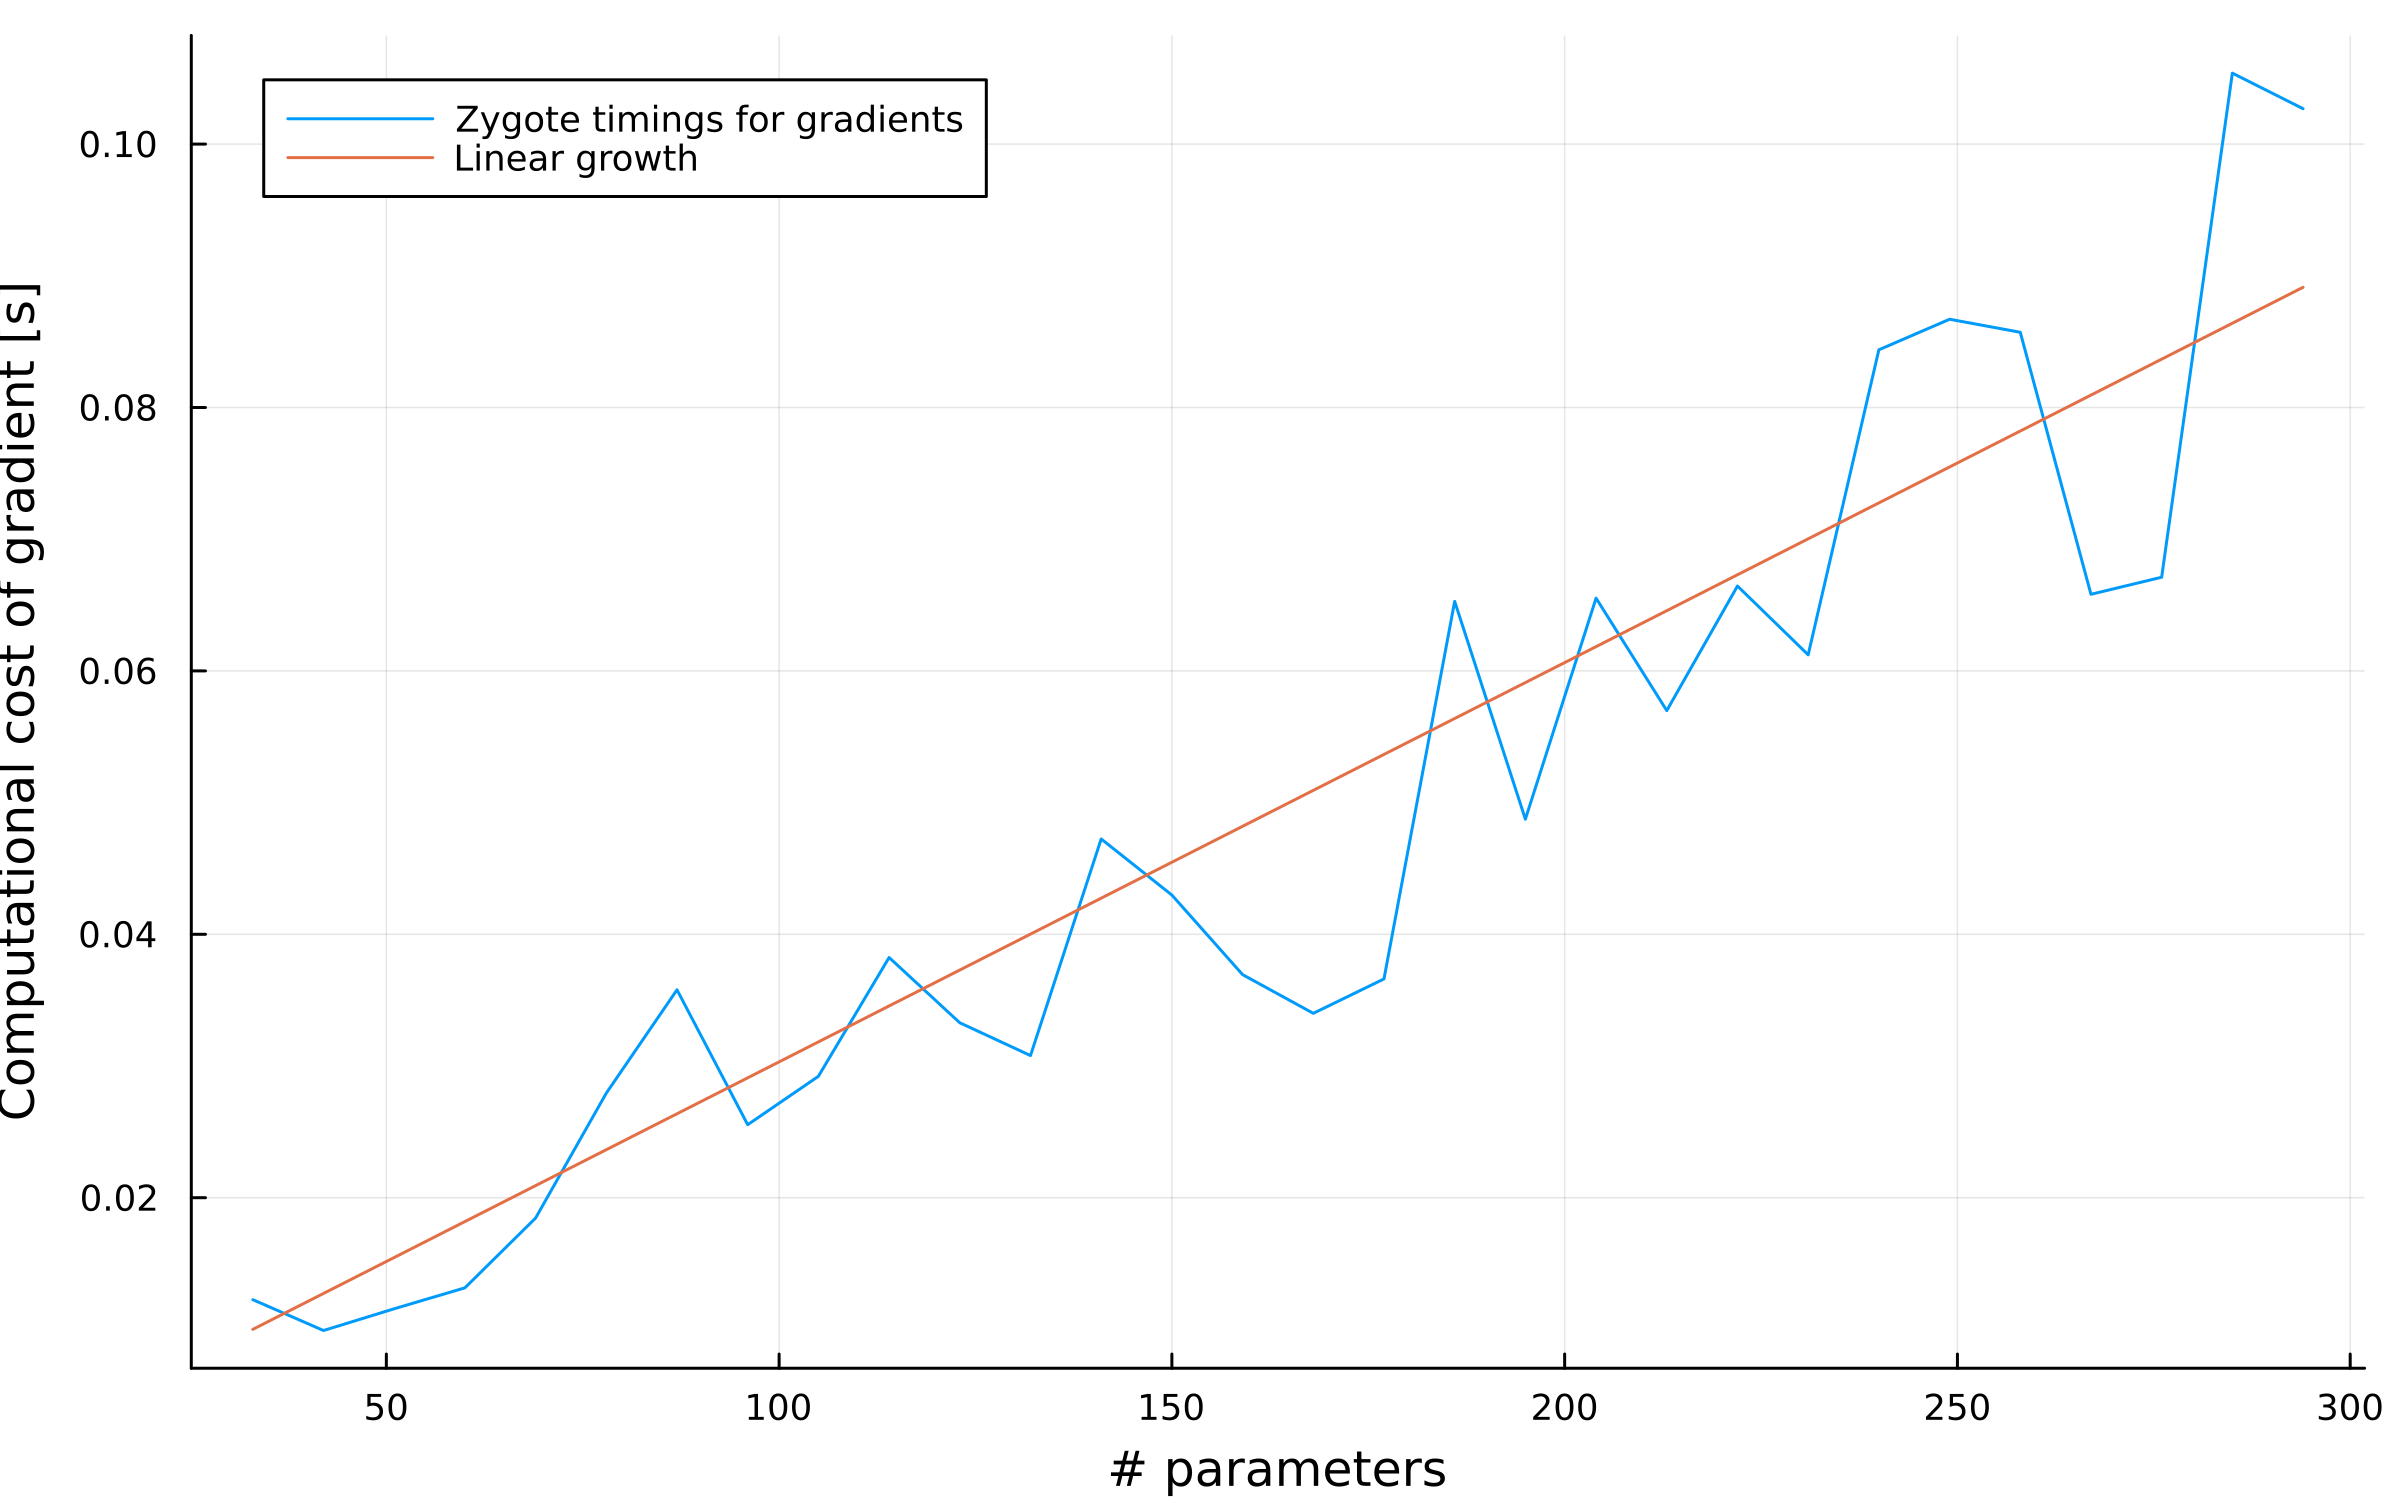

In [35]:

plot(p_sizes_n, timings_n, label="Zygote timings for gradients", size=(800,500), dpi = 300)
xlabel!("# parameters")
ylabel!("Computational cost of gradient [s]")

dtiming_dp_sizes_n = (timings_n[20]-timings_n[10])/(p_sizes_n[20]-p_sizes_n[10])
println("dtiming/dp_sizes = ", dtiming_dp_sizes_n)

plot!(p_sizes_n,(dtiming_dp_sizes_n.*p_sizes_n), label="Linear growth")
#png("NODE_timing.png")

In [ ]:
@benchmark LNN(x_0[1], Rosenbrock23(autodiff = false), p, 1 , false) 

In [ ]:
@benchmark NODE_solve(x_0[1], tsteps, NODE_params)